In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#IMPORTATION DES DIFFERENTES LIBRAIRIES 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from cloudpickle import dump 
import tensorflow as tf
from tensorflow.keras.models  import Sequential, model_from_json
from cloudpickle import dump 
from tensorflow.keras.models  import model_from_json
from cloudpickle import load
from tensorflow.keras.models import model_from_json 
import pandas as pd


In [3]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

**I- IMPORT OF DATA AND LIBRAIRIES**

In [4]:
#Specification de chaque type de données à importer 
dtypes = {'IPV4_SRC_ADDR' : 'category', 'L4_SRC_PORT':'uint32','IPV4_DST_ADDR': 'category', 
'L4_DST_PORT':'uint32' , 'PROTOCOL': 'uint16', 'L7_PROTO': 'float16', 'IN_BYTES': 'uint32', 
'OUT_BYTES': 'uint32', 'IN_PKTS': 'uint32','OUT_PKTS': 'uint32' , 'TCP_FLAGS': 'uint16' , 
'FLOW_DURATION_MILLISECONDS': 'uint32', 'Label': 'uint8', 'Attack': 'category', 
          'Dataset': 'category'}

#Import des données 
df = pd.read_csv('/kaggle/input/nfu-dataset/e3bd3035f88e55fa_MOHANAD_A4706/data/NF-UQ-NIDS.csv', dtype=dtypes)

**II - FEATURE ENGINEERING**

In [5]:
#Verification pour chaque colonne de toutes les valeurs nulles et de leurs  nombres 
unique_values= pd.DataFrame(df.nunique())
null_values=pd.DataFrame(df.isna().sum())

df_info = pd.concat([unique_values, null_values], axis=1)
df_info.columns=['Unique_values_number', 'Null_values_number']
df_info

,Unique_values_number,Null_values_number
IPV4_SRC_ADDR,75630,0
L4_SRC_PORT,65259,0
IPV4_DST_ADDR,27826,0
L4_DST_PORT,65179,0
PROTOCOL,256,0
L7_PROTO,351,0
IN_BYTES,42633,0
OUT_BYTES,75771,0
IN_PKTS,5285,0
OUT_PKTS,3291,0


****1 - SOURCE ADDRESS****

In [6]:
#Split source address into four components: network1, network2, hote1, hote2
df[['IPV4_SRC_ADDR_network1','IPV4_SRC_ADDR_network2', 'IPV4_SRC_ADDR_hote1', 'IPV4_SRC_ADDR_hote2']] = \
df['IPV4_SRC_ADDR'].str.split('.', expand=True)

#1st component: network1
target_encoding_src_network1 = df.groupby('IPV4_SRC_ADDR_network1')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_src_network1.columns=['IPV4_SRC_ADDR_network1','SRC_ADDR_network1_count', 'SRC_ADDR_network1_mean']
df = target_encoding_src_network1.merge(df, on='IPV4_SRC_ADDR_network1')

#2nd component: network2
target_encoding_src_network2 = df.groupby('IPV4_SRC_ADDR_network2')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_src_network2.columns=['IPV4_SRC_ADDR_network2','SRC_ADDR_network2_count', 'SRC_ADDR_network2_mean']
df = target_encoding_src_network2.merge(df, on='IPV4_SRC_ADDR_network2')

#3rd component: hote1
target_encoding_src_hote1 = df.groupby('IPV4_SRC_ADDR_hote1')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_src_hote1.columns=['IPV4_SRC_ADDR_hote1','SRC_ADDR_hote1_count', 'SRC_ADDR_hote1_mean']
df = target_encoding_src_hote1.merge(df, on='IPV4_SRC_ADDR_hote1')

#4th component: hote2
target_encoding_src_hote2 = df.groupby('IPV4_SRC_ADDR_hote2')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_src_hote2.columns=['IPV4_SRC_ADDR_hote2','SRC_ADDR_hote2_count', 'SRC_ADDR_hote2_mean']
df = target_encoding_src_hote2.merge(df, on='IPV4_SRC_ADDR_hote2')

**2 - DESTINATION ADDRESS**

In [8]:
#Split destination address into four components: network1, network2, hote1, hote2
df[['IPV4_DST_ADDR_network1','IPV4_DST_ADDR_network2', 'IPV4_DST_ADDR_hote1', \
'IPV4_DST_ADDR_hote2']] = df['IPV4_DST_ADDR'].str.split('.', expand=True)

#1st component: network1
target_encoding_dst_network1 = df.groupby('IPV4_DST_ADDR_network1')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_dst_network1.columns=['IPV4_DST_ADDR_network1','DST_ADDR_network1_count', 'DST_ADDR_network1_mean']
df = target_encoding_dst_network1.merge(df, on='IPV4_DST_ADDR_network1')

#2nd component: network2
target_encoding_dst_network2 = df.groupby('IPV4_DST_ADDR_network2')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_dst_network2.columns=['IPV4_DST_ADDR_network2','DST_ADDR_network2_count', 'DST_ADDR_network2_mean']
df = target_encoding_dst_network2.merge(df, on='IPV4_DST_ADDR_network2')

#3rd component: hote1
target_encoding_dst_hote1 = df.groupby('IPV4_DST_ADDR_hote1')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_dst_hote1.columns=['IPV4_DST_ADDR_hote1','DST_ADDR_hote1_count', 'DST_ADDR_hote1_mean']
df = target_encoding_dst_hote1.merge(df, on='IPV4_DST_ADDR_hote1')

#4th component: hote2
target_encoding_dst_hote2 = df.groupby('IPV4_DST_ADDR_hote2')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_dst_hote2.columns=['IPV4_DST_ADDR_hote2','DST_ADDR_hote2_count', 'DST_ADDR_hote2_mean']
df = target_encoding_dst_hote2.merge(df, on='IPV4_DST_ADDR_hote2')

**3 - L4_SRC_PORT**

In [10]:
target_encoding_l4_src_port = df.groupby('L4_SRC_PORT')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_l4_src_port.columns=['L4_SRC_PORT','L4_SRC_PORT_count', 'L4_SRC_PORT_mean']
df = target_encoding_l4_src_port.merge(df, on='L4_SRC_PORT')

**4 - L4_DST_PORT**

In [11]:
target_encoding_l4_dst_port = df.groupby('L4_DST_PORT')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_l4_dst_port.columns=['L4_DST_PORT','L4_DST_PORT_count', 'L4_DST_PORT_mean']
df = target_encoding_l4_dst_port.merge(df, on='L4_DST_PORT')

**5 - PROTOCOL**

In [12]:
target_encoding_protocol = df.groupby('PROTOCOL')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_protocol .columns=['PROTOCOL','PROTOCOL_count', 'PROTOCOL_mean']
df= target_encoding_protocol .merge(df, on='PROTOCOL')

**6 - TCP Flags**

In [13]:
target_encoding_tcp_flags = df.groupby('TCP_FLAGS')['Label'].agg(['count', 'mean']).reset_index()
target_encoding_tcp_flags .columns=['TCP_FLAGS','TCP_FLAGS_count', 'TCP_FLAGS_mean']
df = target_encoding_tcp_flags .merge(df, on='TCP_FLAGS')

**III- MODEL IMPLEMENTATION**

****1 - Break normal data and anomalies data****

In [102]:
df_normal

,TCP_FLAGS_count,TCP_FLAGS_mean,PROTOCOL_count,PROTOCOL_mean,L4_DST_PORT_count,L4_DST_PORT_mean,L4_SRC_PORT_count,L4_SRC_PORT_mean,DST_ADDR_hote2_count,DST_ADDR_hote2_mean,...,SRC_ADDR_network2_count,SRC_ADDR_network2_mean,SRC_ADDR_network1_count,SRC_ADDR_network1_mean,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,Label
41,2844421,0.054047,43,0.953613,73639,0.209717,73639,0.209717,33598,0.185303,...,158709,0.926270,704753,0.990723,4584360,0,76406,0,0,0
42,2844421,0.054047,43,0.953613,73639,0.209717,73639,0.209717,50046,0.000360,...,19041,0.000262,210269,0.005760,0,0,0,0,0,0
43,2844421,0.054047,43538,0.092957,73639,0.209717,73639,0.209717,182170,0.000000,...,35983,0.000751,29158,0.000000,168,0,3,0,88618,0
44,2844421,0.054047,43538,0.092957,73639,0.209717,73639,0.209717,182170,0.000000,...,35983,0.000751,29158,0.000000,56,0,1,0,0,0
45,2844421,0.054047,43538,0.092957,73639,0.209717,73639,0.209717,182170,0.000000,...,35983,0.000751,29158,0.000000,168,0,3,0,4021767,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11994886,165731,0.013634,9151668,0.287842,52,0.000000,440271,0.000023,75939,0.110474,...,5390402,0.013504,5388986,0.013512,563,887,9,10,4292735,0
11994887,165731,0.013634,9151668,0.287842,85,0.000000,440271,0.000023,33035,0.003178,...,5390402,0.013504,5388986,0.013512,2183,1968,11,13,4271016,0
11994888,165731,0.013634,9151668,0.287842,46,0.021744,440271,0.000023,247544,0.973633,...,5390402,0.013504,5388986,0.013512,2183,1912,11,11,4291735,0
11994889,165731,0.013634,9151668,0.287842,48,0.000000,440271,0.000023,75939,0.110474,...,5390402,0.013504,5388986,0.013512,673,1086,9,10,4292952,0


In [16]:
#Separer les données normales des données d'anomalies 
df_normal = df[df['Label']==0]
df_attack = df[df['Label']==1]

drop_col = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Attack', 'Dataset', 'TCP_FLAGS', 'PROTOCOL', 'L4_DST_PORT', 'L4_SRC_PORT', 'IPV4_DST_ADDR_hote2','IPV4_DST_ADDR_hote1',
'IPV4_DST_ADDR_network2','IPV4_DST_ADDR_network1', 'IPV4_SRC_ADDR_hote2','IPV4_SRC_ADDR_hote1', 
'IPV4_SRC_ADDR_network2','IPV4_SRC_ADDR_network1', 'L7_PROTO']


#Enlever les colones inutiles 
df_normal = df_normal.drop(columns=drop_col)
df_attack = df_attack.drop(columns=drop_col)

**2 - TRAIN TEST SPLIT**

In [17]:
#Partitionner les données normales en données de test et d'entraînement
X_train, X_test = train_test_split(df_normal.drop(columns='Label'), test_size=0.3, random_state=42)
print(f"Good train count: {len(X_train)}")
print(f"Good test count: {len(X_test)}")

Good train count: 6445632
Good test count: 2762414


**3 - Data normalizing**

In [18]:
#from sklearn.preprocessing import StandardScaler
stdScaler = StandardScaler()
X_train_scaled = stdScaler.fit_transform(X_train)
X_test_scaled  = stdScaler.transform(X_test)

#Scale attack_data 
df_attack_scaled = stdScaler.transform(df_attack.drop(columns='Label'))

# save model
#dump(stdScaler, open('StandardScaler.pkl', 'wb'))

**4 - AUTOENCODER MODEL**

In [19]:
model = Sequential()

model.add(Dense(35, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(25,  activation='relu'))
model.add(Dense(10,  activation='relu'))
model.add(Dense(5, activation='relu'))

model.add(Dense(10, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(50,  activation='relu'))
model.add(Dense(35,  activation='relu'))
model.add(Dense(X_train_scaled.shape[1])) 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
#Ajout d'une fonction de callback 
early_stopping = EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True, 
    verbose=1
)

#Compilation 
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train_scaled,X_train_scaled,verbose=1,epochs=10, batch_size=32, \
validation_data=(X_test_scaled, X_test_scaled), callbacks=[early_stopping], shuffle=True)

Epoch 1/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 416s 2ms/step - loss: 0.1282 - val_loss: 0.0940
Epoch 2/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0900 - val_loss: 0.0844
Epoch 3/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 410s 2ms/step - loss: 0.0841 - val_loss: 0.0865
Epoch 4/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0825 - val_loss: 0.0815
Epoch 5/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0822 - val_loss: 0.0815
Epoch 6/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 410s 2ms/step - loss: 0.0814 - val_loss: 0.0812
Epoch 7/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0818 - val_loss: 0.0846
Epoch 8/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0830 - val_loss: 0.0837
Epoch 9/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0836 - val_loss: 0.0875
Epoch 10/10
201426/201426 ━━━━━━━━━━━━━━━━━━━━ 409s 2ms/step - loss: 0.0862 - val_loss: 0.0868
Restoring model weights from the end of the best epoch: 4.


In [25]:
from tensorflow.keras.models  import Sequential, model_from_json
from cloudpickle import dump 

processing = {'target_encoding_src_network1': target_encoding_src_network1,
                   'target_encoding_src_network2': target_encoding_src_network2,
                   'target_encoding_src_hote1' : target_encoding_src_hote1,
                   'target_encoding_src_hote2' : target_encoding_src_hote2,
                   'target_encoding_dst_network1': target_encoding_dst_network1,
                   'target_encoding_dst_network2': target_encoding_dst_network2,
                   'target_encoding_dst_hote1' : target_encoding_dst_hote1,
                   'target_encoding_dst_hote2' : target_encoding_dst_hote2,
                   'target_encoding_l4_src_port': target_encoding_l4_src_port,
                   'target_encoding_l4_dst_port': target_encoding_l4_dst_port,
                   'target_encoding_protocol': target_encoding_protocol,
                   'target_encoding_tcp_flags': target_encoding_tcp_flags,
                   'stdScaler': stdScaler,
                    'threshold': threshold}
dump(processing, open('processing.pkl', 'wb'))

#serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
model.save_weights("model.weights.h5")
print('Saved model to disk')  

Saved model to disk


****5 - PREDICTION****

**a-Train data**

In [22]:
reconstructions_train = model.predict(X_train_scaled)
train_loss = tf.keras.losses.mae(reconstructions_train, X_train_scaled)

201426/201426 ━━━━━━━━━━━━━━━━━━━━ 246s 1ms/step


In [23]:
#Definir le seuil 
threshold= np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

# save model
dump(threshold, open('threshold.pkl', 'wb'))

Threshold:  0.21527827744118957


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


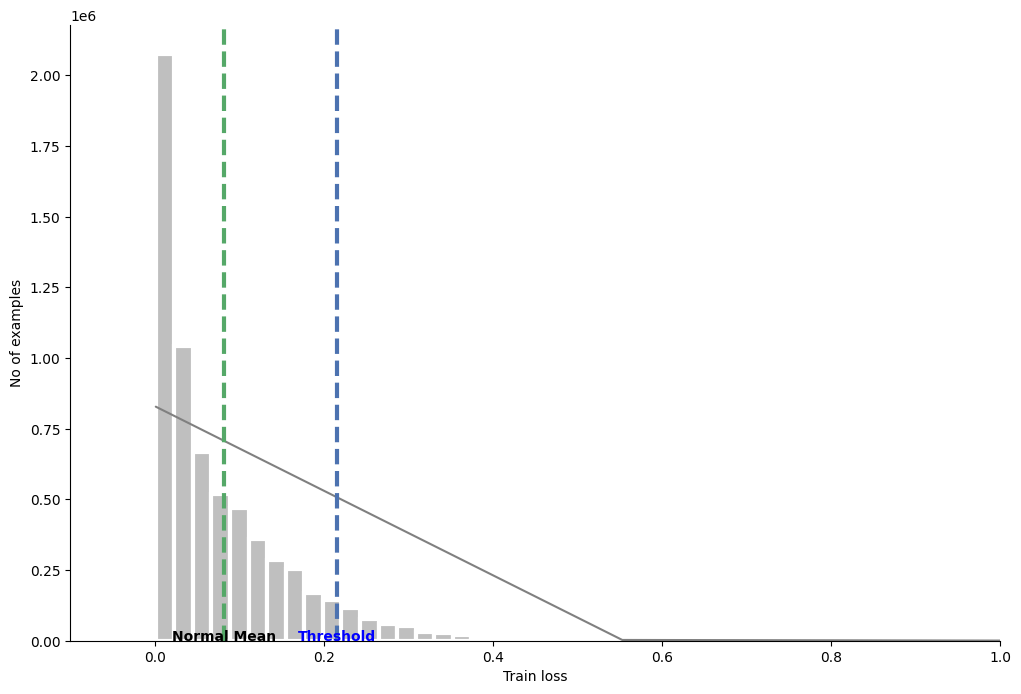

In [24]:
#Visualiser les erreurs des données d'entrainement
plt.figure(figsize=(12,8))
plt.xlim(-0.1,1)
sns.set(font_scale = 1)
sns.set_style("white")
sns.histplot(train_loss ,bins=5000,kde=True,color='grey',linewidth=3)
plt.axvline(x=np.mean(train_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(train_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()

**As **

**b -Test data**

In [26]:
reconstructions_test = model.predict(X_test_scaled)
test_loss = tf.keras.losses.mae(reconstructions_test, X_test_scaled)

86326/86326 ━━━━━━━━━━━━━━━━━━━━ 107s 1ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


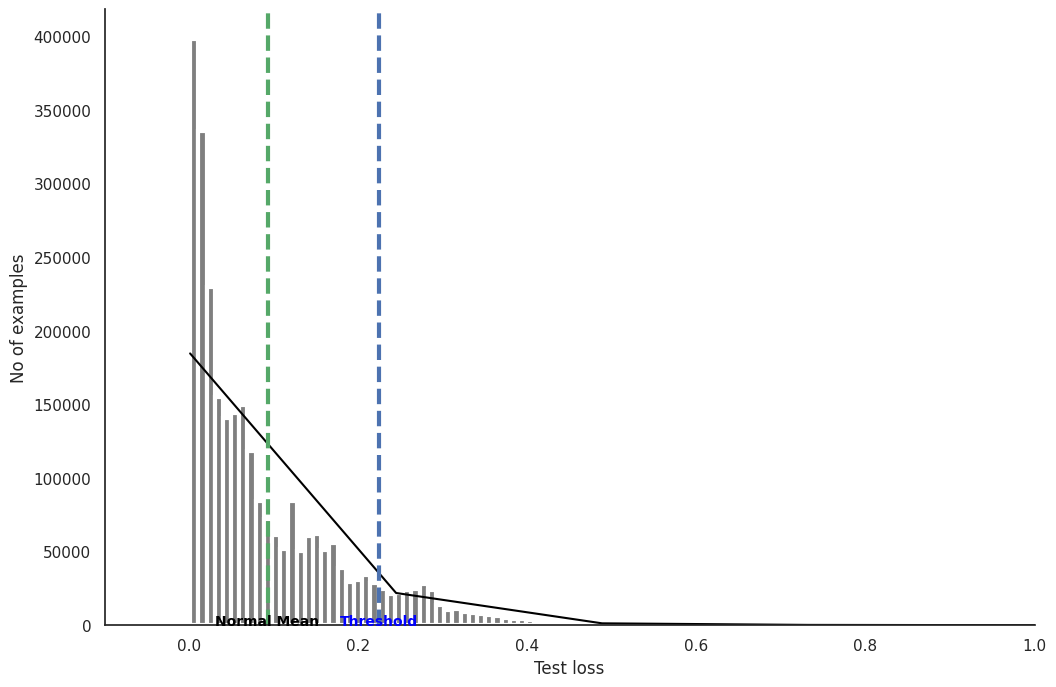

In [95]:
#Visualiser les erreurs  des données de test
plt.figure(figsize=(12,8))
plt.xlim(-0.1,1)
sns.set(font_scale = 1)
sns.set_style("white")
sns.histplot(test_loss ,bins=5000,kde=True,color='black',linewidth=3)
plt.axvline(x=np.mean(test_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(test_loss), 200, "Normal Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.text(threshold, 250, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
sns.despine()

In [96]:
outliers = test_loss > threshold
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(test_loss):,} transactions\
      [{np.sum(outliers)/np.size(test_loss):.2%}] ")

Detected 291,722 outliers in a total of 2,762,414 transactions      [10.56%] 


**c- Anomalous data**

In [27]:
reconstructions_anomaly = model.predict(df_attack_scaled)
attack_loss = tf.keras.losses.mae(reconstructions_anomaly, df_attack_scaled)

87089/87089 ━━━━━━━━━━━━━━━━━━━━ 109s 1ms/step


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


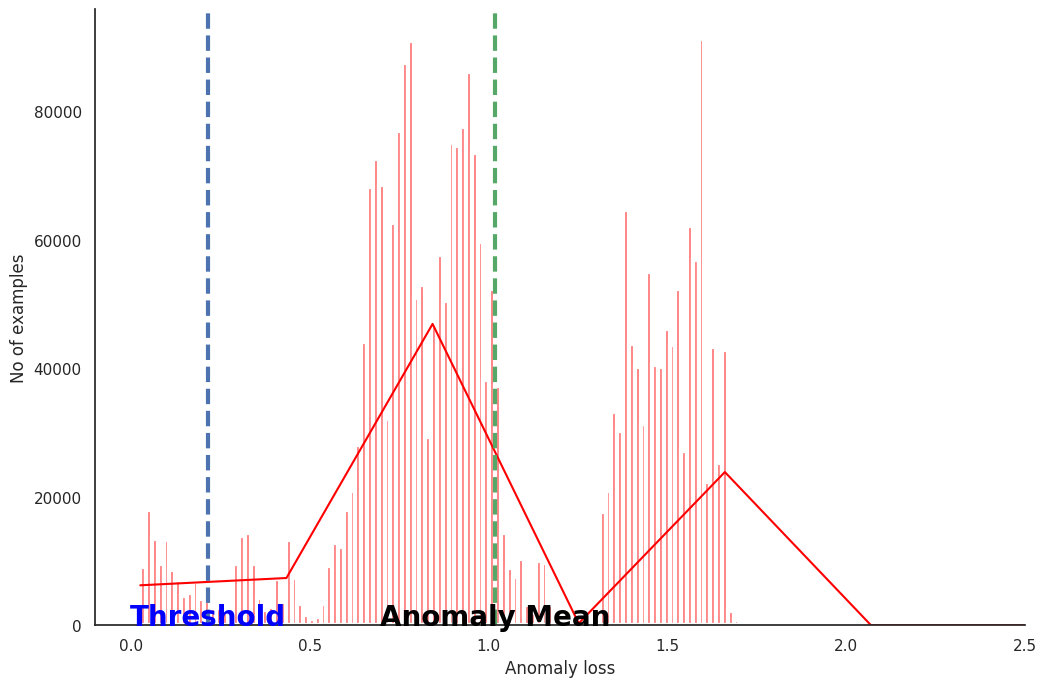

In [28]:
plt.figure(figsize=(12,8))
plt.xlim(-0.1,2.5)
sns.set(font_scale = 2)
sns.set_style("white")
sns.histplot(attack_loss ,bins=5000,kde=True,color='red',linewidth=3)
plt.axvline(x=np.mean(attack_loss), color='g', linestyle='--', linewidth=3)
plt.text(np.mean(attack_loss), 30, "Anomaly Mean", horizontalalignment='center', 
         size='small', color='black', weight='semibold')
plt.text(threshold, 50, "Threshold", horizontalalignment='center', 
         size='small', color='Blue', weight='semibold')
plt.axvline(x=threshold, color='b', linestyle='--', linewidth=3)
plt.xlabel("Anomaly loss")
plt.ylabel("No of examples")
sns.despine()

In [99]:
outliers = attack_loss > threshold
print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(attack_loss):,} transactions [{np.sum(outliers)/np.size(attack_loss):.2%}].")

Detected 2,699,594 outliers in a total of 2,786,845 transactions [96.87%].


**Sauvegarde du modele**

In [ ]:
processing = {'target_encoding_src_network1': target_encoding_src_network1,
                   'target_encoding_src_network2': target_encoding_src_network2,
                   'target_encoding_src_hote1' : target_encoding_src_hote1,
                   'target_encoding_src_hote2' : target_encoding_src_hote2,
                   'target_encoding_dst_network1': target_encoding_dst_network1,
                   'target_encoding_dst_network2': target_encoding_dst_network2,
                   'target_encoding_dst_hote1' : target_encoding_dst_hote1,
                   'target_encoding_dst_hote2' : target_encoding_dst_hote2,
                   'target_encoding_l4_src_port': target_encoding_l4_src_port,
                   'target_encoding_l4_dst_port': target_encoding_l4_dst_port,
                   'target_encoding_protocol': target_encoding_protocol,
                   'target_encoding_tcp_flags': target_encoding_tcp_flags,
                   'stdScaler': stdScaler,
                    'threshold': threshold}
dump(processing, open('processing.pkl', 'wb'))

#serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

#serialize weights to HDF5
model.save_weights("model.weights.h5")
print('Saved model to disk')

In [ ]:
# load json and create model
json_file = open('/kaggle/input/final-model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/kaggle/input/final-model/model.weights.h5")